<a href="https://colab.research.google.com/github/oneonethree113/Trajectory-Analysis/blob/main/AMAG_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download data

In [ ]:

!pip install gdown
file_id = '1tVAiE6OQRUwQReu2tbiChKDZeL_zbu_V'
output_file = 'trajectories.json'  # Save as a JSON file

# Construct the download link
download_link = f'https://drive.google.com/uc?id={file_id}'

# Download the file using gdown
!gdown $download_link -O $output_file


Downloading...
From: https://drive.google.com/uc?id=1tVAiE6OQRUwQReu2tbiChKDZeL_zbu_V
To: /content/trajectories.json
100% 749k/749k [00:00<00:00, 125MB/s]


Import library

In [ ]:

from collections import Counter
import json
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram,fcluster


You can edit the hyperparameters here

In [ ]:

# Define hyper-parameters
windowSize = 200  # The window size for trajectory comparison
distanceThreshold = 0.8  # The threshold for merge clusters
sampleSize = 1000  # The number of trajectories to process
numMostCommonGroupToDisplay = 20  # The number of trajectories clusters shown on the full picture



Define the class Coordinates and Trajectory

In [ ]:
class Coordinates:
    """
    Represents a point with x and y coordinates.

    Args:
        coordinateList (list): A list containing x and y coordinates.

    Attributes:
        x (float): The x-coordinate.
        y (float): The y-coordinate.
    """
    def __init__(self, coordinateList: list):
        self.x = float(coordinateList[0])
        self.y = float(coordinateList[1])

    def withinFilter(self, tar_cor: 'Coordinates', window_size: int) -> bool:
        """
        Checks if the current coordinate is within a given window around the target coordinate.

        Args:
            tar_cor (Coordinates): The target coordinate to compare with.
            window_size (float): The size of the window.

        Returns:
            bool: True if the current coordinate is within the window around the target coordinate, False otherwise.
        """

        if not isinstance(tar_cor, Coordinates):
            raise TypeError("tar_cor must be an instance of Coordinates.")

        if not isinstance(window_size, int):
            raise TypeError("window_size must be a float.")

        return (tar_cor.x <= self.x + window_size/2) and \
               (tar_cor.x >= self.x - window_size/2) and \
               (tar_cor.y <= self.y + window_size/2) and \
               (tar_cor.y >= self.y - window_size/2)

class Trajectory:
    """
    Represents a trajectory with a unique ID, type, and a list of coordinates.

    Args:
        entity (dict): A dictionary representing the trajectory entity.

    Attributes:
        id (str): The unique identifier of the trajectory.
        type (str): The type of the trajectory.
        traj (list): A list of Coordinates objects representing the trajectory path.
    """
    def __init__(self, entity: dict):
        self.id = entity['object_id']
        self.type = entity['object_type']
        self.traj = [Coordinates(cor.split(',')) for cor in entity['coordinates'].split()]

    def similarity(self, target_traj: 'Trajectory', window_size: int) -> float:
        """
        Calculates the similarity score of the two trajectories's direction between based on their coordinates.
        The idea of the calculation method is from https://en.wikipedia.org/wiki/Dilation_(morphology)

        Args:
            target_traj (Trajectory): The target trajectory to compare with.
            window_size (float): The size of the window for coordinate comparison.

        Returns:

            float: The similarity score between the two trajectories. The score is within the range of 0 to 1,
                   where 0 indicates no similarity and 1 indicates maximum similarity.
        """


        if not isinstance(target_traj, Trajectory):
            raise TypeError("target_traj must be an instance of Trajectory.")

        if not isinstance(window_size, int):
            raise TypeError("window_size must be a int.")

        score = 0
        for cor in self.traj:
            for tar in target_traj.traj:
                if cor.withinFilter(tar, window_size):
                    score += 1
                    break
        for cor in target_traj.traj:
            for tar in self.traj:
                if cor.withinFilter(tar, window_size):
                    score += 1
                    break
        return score / (len(self.traj) + len(target_traj.traj))
    def trajExport(self):
        """
        Extracts x and y coordinates from the trajectory.

        Returns:
            tuple: A tuple containing two lists. The first list contains x-coordinates and the second list contains y-coordinates.
        """
        x_coords = [cor.x for cor in self.traj]
        y_coords = [cor.y for cor in self.traj]
        return x_coords, y_coords

Load data

In [ ]:

# Read and parse trajectory data from the JSON file
with open(r'trajectories.json') as dataFile:
    fileContents = dataFile.read()

parsedJson = json.loads(fileContents)

# Create a list of Trajectory instances from the parsed JSON data
parsedTrajectoryList = [Trajectory(entity) for entity in parsedJson[:sampleSize]]

Calculate the similarity of trajectory

In [ ]:

def generateDistanceMap(parsedTrajectoryList: list, windowSize: int) -> np.ndarray:
    """
    Generate a similarity-based distance map for a list of trajectories  using idea of Dilation in image processing.
    The distance is calculated by how many coordinations of the both trajectories near the next trajectory.

    Args:
        parsedTrajectoryList (list): A list of Trajectory instances.
        windowSize (int): Size of the window for similarity calculation.

    Returns:
        numpy.ndarray: A NumPy array containing the similarity-based distance map.
    """
    print(f'There are {len(parsedTrajectoryList)} trajectories in the dataset')

    distanceMap = np.zeros((len(parsedTrajectoryList), len(parsedTrajectoryList)))

    # Calculate the similarity-based distance map
    for i, entity in enumerate(parsedTrajectoryList):
        disArray = []  # Initialize an array to store distances from the current entity

        if i % 10 == 0:
            print(f'{i} of {len(parsedTrajectoryList)} trajectories has been processed')

        # Calculate similarity with all other trajectories
        for j, entity2 in enumerate(parsedTrajectoryList):
            if i > j:
                continue
            distance = 1 - entity.similarity(entity2, windowSize)  # Calculate the similarity
            distanceMap[i][j] = distance
            distanceMap[j][i] = distance

    print(f'All trajectories have been processed')

    return distanceMap

# Generate the distance map
distanceMap = generateDistanceMap(parsedTrajectoryList, windowSize)


There are 839 trajectories in the dataset
0 of 839 trajectories has been processed
10 of 839 trajectories has been processed
20 of 839 trajectories has been processed
30 of 839 trajectories has been processed
40 of 839 trajectories has been processed
50 of 839 trajectories has been processed
60 of 839 trajectories has been processed
70 of 839 trajectories has been processed
80 of 839 trajectories has been processed
90 of 839 trajectories has been processed
100 of 839 trajectories has been processed
110 of 839 trajectories has been processed
120 of 839 trajectories has been processed
130 of 839 trajectories has been processed
140 of 839 trajectories has been processed
150 of 839 trajectories has been processed
160 of 839 trajectories has been processed
170 of 839 trajectories has been processed
180 of 839 trajectories has been processed
190 of 839 trajectories has been processed
200 of 839 trajectories has been processed
210 of 839 trajectories has been processed
220 of 839 trajectories

Perform hierarchical clustering on a distance map with ski-learn.

In [ ]:

def formClusterOfTrajectory(distanceMap: np.ndarray, distanceThreshold: float) -> np.ndarray:
    """
    Perform hierarchical clustering on a distance map with ski-learn.

    Args:
        distanceMap (numpy.ndarray): Distance map for entities.
        distanceThreshold (float): Threshold for flat clustering.

    Returns:
        numpy.ndarray: Cluster assignments.
    """
    hierarchicalClusters = linkage(distanceMap, method='single')  # Calculate hierarchical linkage
    maxDistance = distanceThreshold * 2  # Maximum distance for flat clustering

    return fcluster(hierarchicalClusters, t=maxDistance, criterion='distance')

# Form clusters of trajectories based on distance map and threshold
clusters = formClusterOfTrajectory(distanceMap, distanceThreshold)


<ipython-input-33-b044cfe366fe>:12: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  hierarchicalClusters = linkage(distanceMap, method='single')  # Calculate hierarchical linkage


Figure out the largest clusters from the above result


In [ ]:

def getBigCluster(clusters: list, numMostCommonGroupToDisplay: int) -> dict:
    """
    Identify and return the largest clusters from a list of clusters.

    Args:
        clusters (list): List of cluster assignments for data points.
        numMostCommonGroupToDisplay (int): Number of most common clusters to display.

    Returns:
        dict: Dictionary containing the largest clusters and their member indices.
    """
    clusterMembers = {}  # Create a dictionary to store cluster memberships

    # Assign data points to clusters
    for idx, clusterId in enumerate(clusters):
        if clusterId in clusterMembers:
            clusterMembers[clusterId].append(idx)
        else:
            clusterMembers[clusterId] = [idx]

    clusterSizes = Counter(clusters)  # Count the size of each cluster
    largestClusters = clusterSizes.most_common(numMostCommonGroupToDisplay)  # Find the largest clusters

    bigCluster = {}
    for cluster, size in largestClusters:
        bigCluster[len(bigCluster)] = clusterMembers[cluster]

    return bigCluster
# Get the biggest clusters for visualization
bigCluster = getBigCluster(clusters, numMostCommonGroupToDisplay)


Visualization

<ipython-input-54-1f4340693819>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab20', num_colors)


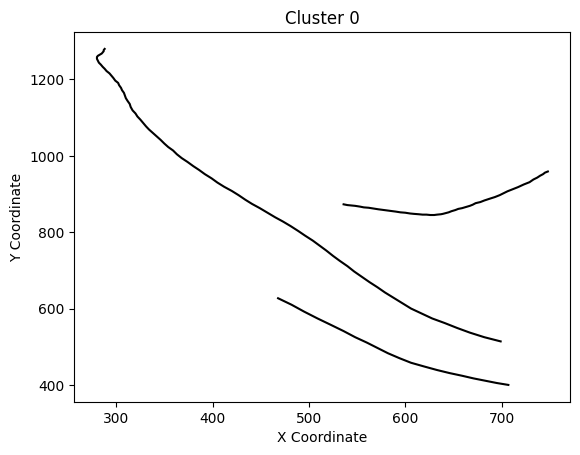

<Figure size 640x480 with 0 Axes>

In [ ]:

def generate_distinct_colors(num_colors: int) ->list:
    if not isinstance(num_colors, int):
        raise TypeError("num_colors must be a int.")
    # Get a colormap with the desired number of colors
    colormap = cm.get_cmap('tab20', num_colors)

    # Generate a list of distinct colors
    distinct_colors = [colormap(i) for i in range(num_colors)]

    return distinct_colors
def drawClusterOnAllPraj(allTrajectory: list,clusterSet: dict,clusterIdx=None,title='')->None:
    if not isinstance(allTrajectory, list):
        raise TypeError("allTrajectory must be a list.")
    if not isinstance(clusterSet, dict):
        raise TypeError("clusterSet must be a dict.")
    if not isinstance(title, str):
        raise TypeError("title must be a str.")

    #colors for visualization
    cluster_colors=generate_distinct_colors(len(clusterSet))
    clusterPrajList=[]
    if clusterIdx==None:
        for cluster_idx,cluster in clusterSet.items():
            for mem in cluster:
                clusterPrajList.append(mem)
        for idx,traj in enumerate(allTrajectory):
            if idx in clusterPrajList:
                continue
                #[4, 1, 5, 8, 0, 6, 7, 3, 11]
            if traj.type !=:
                continue
            x_coords, y_coords = traj.trajExport()
            plt.plot(x_coords, y_coords, color='black')
        for cluster_idx,cluster in clusterSet.items():
            for mem in cluster:
                traj=allTrajectory[mem]
                x_coords, y_coords = traj.trajExport()
                plt.plot(x_coords, y_coords, color=cluster_colors[cluster_idx])
        # Add labels and title
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.title(title)
        plt.show()
        plt.clf()
    else:
        for mem in clusterSet[clusterIdx]:
            clusterPrajList.append(mem)

        for idx,traj in enumerate(allTrajectory):
            if idx in clusterPrajList:
                continue
            x_coords, y_coords = traj.trajExport()
            plt.plot(x_coords, y_coords, color='black')

        for mem in clusterSet[clusterIdx]:
            traj=allTrajectory[mem]
            x_coords, y_coords = traj.trajExport()
            plt.plot(x_coords, y_coords, color=cluster_colors[clusterIdx])


        # Add labels and title
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.title(title)
        plt.show()
        plt.clf()

# Visualize each big cluster
drawClusterOnAllPraj(parsedTrajectoryList, {},  title=f'Cluster 0')


In [ ]:
typeList=[]
for idx,traj in enumerate(parsedTrajectoryList):
  if traj.type not in typeList:
    typeList.append(traj.type)
typeList

[4, 1, 5, 8, 0, 6, 7, 3, 11]

<ipython-input-35-89031d8942f8>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab20', num_colors)


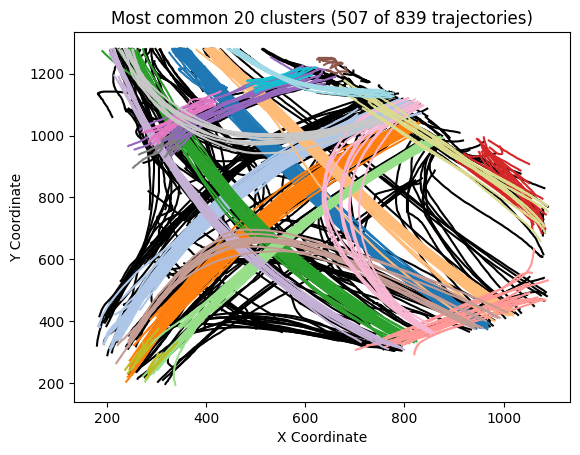

<Figure size 640x480 with 0 Axes>

In [ ]:

numPrajInBigCluster = sum([len(cluster) for _, cluster in bigCluster.items()])
# Visualize all big clusters and other trajectories in one image
drawClusterOnAllPraj(parsedTrajectoryList, bigCluster,
                      title=f'Most common {numMostCommonGroupToDisplay} clusters ({numPrajInBigCluster} of {len(parsedTrajectoryList)} trajectories)')